# Malaria Commodity Prediction
County predictions for malaria commodities.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import preprocessing
import seaborn as sns
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime

## Describe and view the data set we have
We want the date column and the demand prediction. So we use pandas <b>read_csv</b> argument of 'usecols=<['col1','col2',...,'coln']>
<br>
We also drop null values using pandas dropna()

A string input is required to specify the county

In [3]:
#the format of entering a county should be - Nakuru County
input_county=input("Enter County: \n")

In [5]:
dataframe=pd.read_csv('../Data/data.csv',usecols=['periodid',input_county]).dropna()
#retieve 4 rows
dataframe.head(4)

,periodid,Nakuru County
0,2022-01,998
1,2022-02,1159
2,2022-03,1268
3,2022-04,909


In [6]:
dataframe.head(3)

,periodid,Nakuru County
0,2022-01,998
1,2022-02,1159
2,2022-03,1268


In [7]:
dataframe['periodid']=pd.to_datetime(dataframe['periodid'])
dset_indexed=dataframe.set_index(['periodid'])
dset_indexed.head(4)

,Nakuru County
periodid,
2022-01-01,998
2022-02-01,1159
2022-03-01,1268
2022-04-01,909


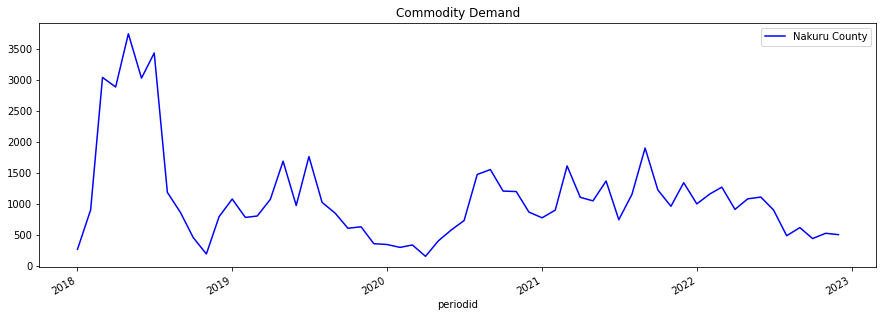

In [8]:
dset_indexed.plot(style='-', figsize=(15,5),color='blue',title='Commodity Demand')
plt.show()

## Train Test Split of the Data
We are not using random split since that would be very wrong instead do an assignment

In [9]:
#train data
#upper bound
train=dset_indexed.loc[dset_indexed.index<'01-01-2021']
#test data
#lower bound
test=dset_indexed.loc[dset_indexed.index>='01-01-2021']

We need to visualize this hence need for using matplot in order to see

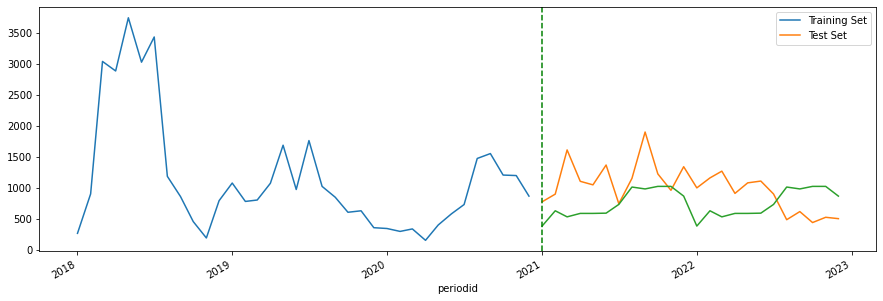

In [203]:
fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Train Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021',color='green',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

## Investigating Internal Trends
Investigating further to look for interesting insight

In [21]:
#this code takes in the year to investigate the trend in the past year e.g. 2018-1-1
#we add some exception handling for an error that will occur

initial_date=datetime(*map(int,input("Key in date in the format yyyy-mm-dd: ").split("-")))
final_date=datetime(*map(int,input("Key in date in the format yyyy-mm-dd: ").split("-")))



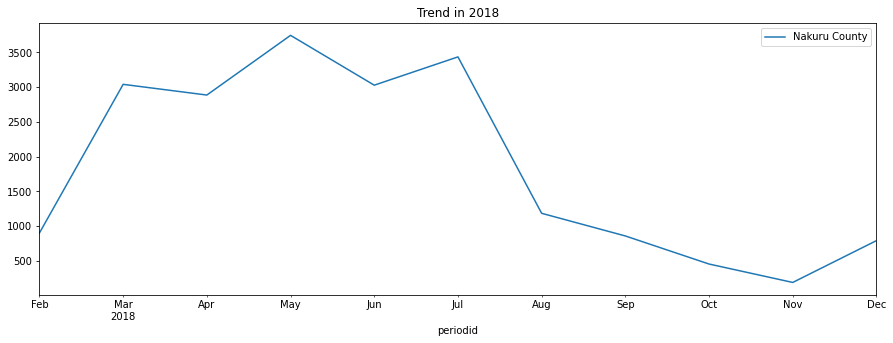

In [22]:
dset_indexed.loc[(dset_indexed.index>initial_date)&(dset_indexed.index<final_date)].plot(figsize=(15,5), title='Trend in 2018')
plt.show()

The below is just a simple demonstration of how one would manually enter the dates without doing inputs at runtime.

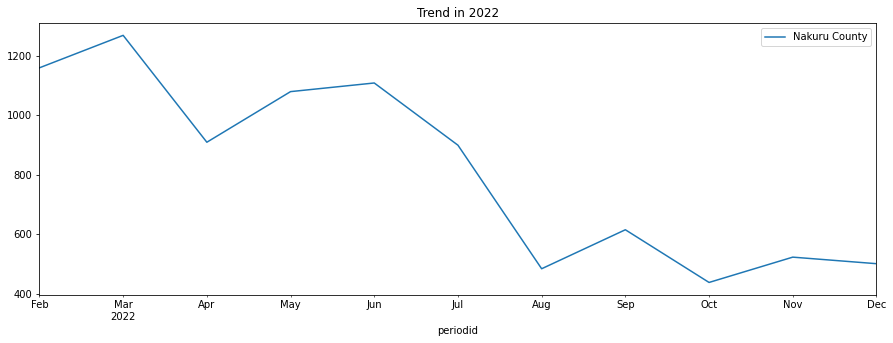

In [23]:
dset_indexed.loc[(dset_indexed.index>'01-01-2022')&(dset_indexed.index<'12-31-2022')].plot(figsize=(15,5), title='Trend in 2022')
plt.show()

## Generating Features
We generate our features using time series index, where it is provided by pandas

In [24]:

def feature_generator(dF):
    dF=dF.copy()
    dF['year']=dF.index.year#year
    dF['month']=dF.index.month #we get month from our datetime index
    
    return dF


In [25]:
df=feature_generator(dset_indexed)
df.head()


,Nakuru County,year,month
periodid,,,
2022-01-01,998,2022,1
2022-02-01,1159,2022,2
2022-03-01,1268,2022,3
2022-04-01,909,2022,4
2022-05-01,1079,2022,5


Doing some few check ups

In [45]:
df[input_county].describe() #some descriptive statistics on the data

count      60.000000
mean     1093.316667
std       765.678905
min       151.000000
25%       612.250000
50%       934.000000
75%      1209.750000
max      3745.000000
Name: Nakuru County, dtype: float64

In [57]:
#check for missing values
missing_values=df.isnull().sum()
number_cols=missing_values.count()

for value in missing_values:
    if value!=0:
        print(f"There are missing value(s)\n{missing_values}")
        break
    elif value==0:
        print("There are no missing values")
        break

There are no missing values


In [58]:
#check for Nan values
nan_values=df.isna().sum()
for value in nan_values:
    if value!=0:
        print(f"There are Nan value(s)\n{nan_values}")
        break
    elif value==0:
        print("There are no Nan values")
        break


There are no Nan values


### Some of the basic discoveries with our new features
Let's use a box plot and see the distribution of the data frame

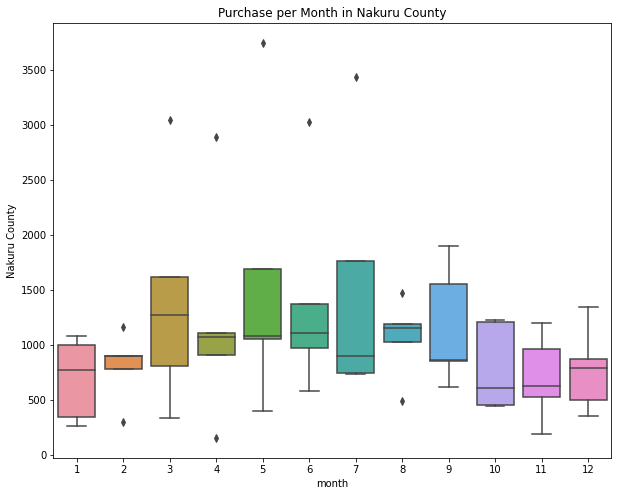

In [59]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y=input_county)# the county specified at the top
ax.set_title(f"Purchase per Month in {input_county}")
plt.show()

# Model Development

In [119]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [61]:
#run train and test through features function to create features we are going to use
train_set=feature_generator(train)
test_set=feature_generator(test)


In [62]:
FEATURES=['year','month']
TARGET=input_county

In [89]:
X_train=train_set[FEATURES]
y_train=train_set[TARGET]

X_test=test_set[FEATURES]
y_test=test_set[TARGET]


In [168]:

model_pipeline=Pipeline([('scaler',StandardScaler()),('gbr',GradientBoostingRegressor(n_estimators=2500,loss='absolute_error',learning_rate=0.001))])


In [169]:
#we fit the ML pipeline
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.001,
                                           loss='absolute_error',
                                           n_estimators=2500))])

In [68]:
#model
#reg=xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
#reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

### How important are the features I have?
Let's look at some of the features generated and make a conclusion.

In [57]:
#fimportance=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_, columns=['Importance'])

This terms quater prediction as an inaccurate strategy for prediction of commodities. Meanwhile, the month features makes it to the spot light as of the highest importance.

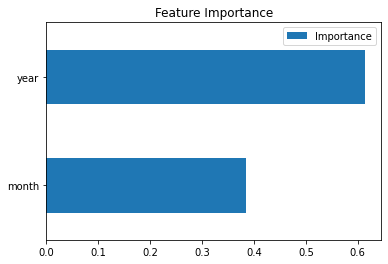

In [58]:
#fimportance.sort_values('Importance').plot(kind='barh',title='Feature Importance')
#plt.show()

## Making Predictions
Since the model has been established it is now important to do forecasting/ prediction.

In [172]:
#test['prediction']=reg.predict(X_test)
test['prediction']=model_pipeline.predict(X_test)
test['prediction'].head(3)

C:\Users\theop\AppData\Local\Temp\ipykernel_17232\4042427014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=model_pipeline.predict(X_test)


periodid
2022-01-01    381.173134
2022-02-01    628.028534
2022-03-01    529.974091
Name: prediction, dtype: float64

In [174]:
model_mse=mean_squared_error(y_test,test['prediction'])
print(f"Performance: {model_mse**0.5}")

Performance: 524.4674085687878


In [175]:
df=df.merge(test[['prediction']], how='left',left_index=True,right_index=True)
df.head()

,Nakuru County,year,month,prediction
periodid,,,,
2022-01-01,998,2022,1,381.173134
2022-02-01,1159,2022,2,628.028534
2022-03-01,1268,2022,3,529.974091
2022-04-01,909,2022,4,585.738328
2022-05-01,1079,2022,5,585.738328


### Show predictions on top of original data

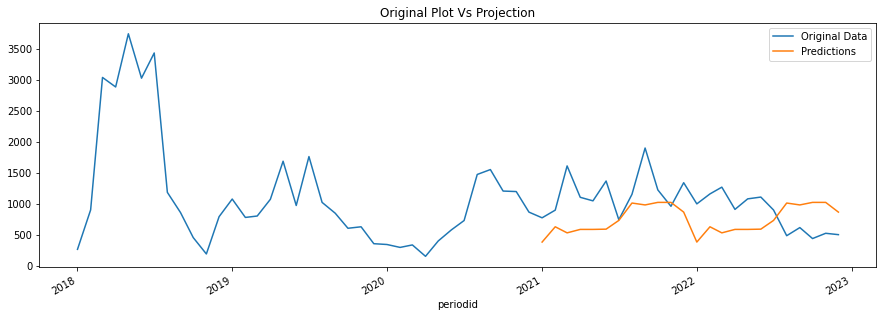

In [180]:
ax=df[input_county].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='-')
plt.legend(['Original Data','Predictions'])
ax.set_title('Original Plot Vs Projection')
plt.show()

### Now Look at the prediction with same trends that were intorduced

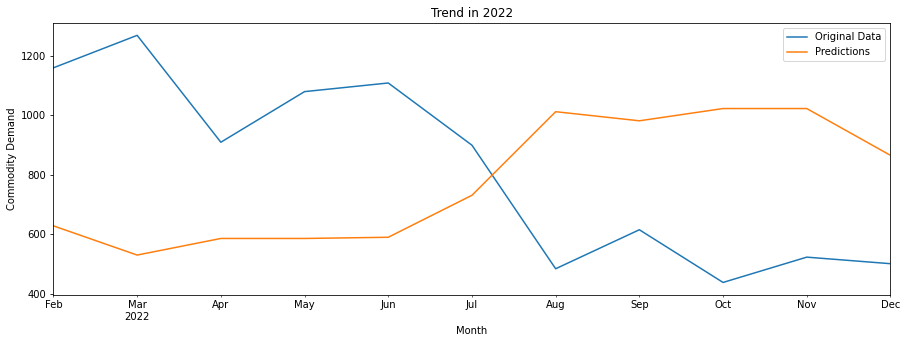

In [182]:
ax=df.loc[(df.index>'01-01-2022')&(df.index<'12-31-2022')]['Nakuru County']\
 .plot(figsize=(15,5), title='Trend in 2022')
df.loc[(df.index>'01-01-2022')&(df.index<'12-31-2022')]['prediction']\
    .plot(style='-')
plt.xlabel('Month')
plt.ylabel('Commodity Demand')
plt.legend(['Original Data','Predictions'])
plt.show()

## Evaluating and Getting the performance
We will use either RMSE or MSE

In [183]:
error=np.sqrt(mean_squared_error(test['Nakuru County'],test['prediction']))
print(f'Root Mean Squared Root: {error:.2f}')

Root Mean Squared Root: 524.47


Further experiments

In [184]:
starting_date='2022-01'
end_date='2022-05'

dates_array=[]
dates=pd.date_range(starting_date,end_date)
for date in dates:
    dates_array.append([date.year,date.month])
transf_dates_array=np.unique(dates_array,axis=0)

print(transf_dates_array)



#print(int(starting_date[5:]))

[[2022    1]
 [2022    2]
 [2022    3]
 [2022    4]
 [2022    5]]


In [185]:
date_input=pd.DataFrame(data=transf_dates_array,columns=['year','month'])
date_input
y_hat=model_pipeline.predict(date_input)
y_hat



array([381.17313422, 628.02853365, 529.97409112, 585.73832773,
       585.73832773])

[1 2 3 4 5]


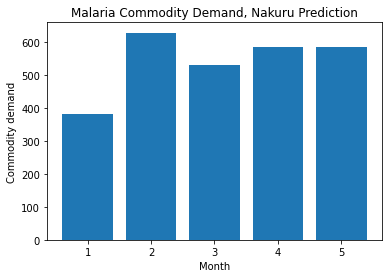

In [192]:
y_bar=y_hat
x_bar=transf_dates_array[:,1]
plt.xlabel('Month')
plt.ylabel('Commodity demand')
plt.title('Malaria Commodity Demand, Nakuru Prediction')
plt.bar(x_bar,y_bar)
plt.show()


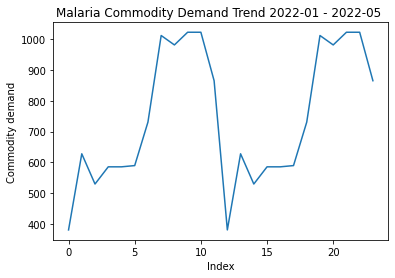

In [200]:
import matplotlib.pyplot as plt

# ...

# Make predictions using the model
predictions = model_pipeline.predict(X_test)

# Create an array of indices for the x-axis
x_bar = range(len(predictions))

# Plot the increasing trend line
plt.plot(x_bar, predictions)
plt.xlabel('Index')
plt.ylabel('Commodity demand')
plt.title(f"Malaria Commodity Demand Trend {starting_date} - {end_date} ")
plt.show()
